# Topic 2: Tool Integration for Agents

**Learning Objectives:**
- Understand what tools are and why agents need them
- Create tools using the `@tool` decorator
- Bind tools to LLMs for function calling
- Implement conditional routing based on tool calls
- Build an agent that decides which tools to use

**Prerequisites:** Topic 1 (LangGraph Basics)


---
## Section 1: Why Do Agents Need Tools?

### The Problem: LLMs Can't Do Everything

LLMs are great at:
- ✅ Understanding language
- ✅ Generating text
- ✅ Reasoning about information

But they **can't**:
- ❌ Search the web in real-time
- ❌ Perform precise calculations
- ❌ Access databases or files
- ❌ Call APIs
- ❌ Execute code

### The Solution: Tools!

**Tools** are functions that agents can call to perform actions:

```
User: "What's 12345 * 67890?"

Agent thinks: "I need to calculate this precisely"
         ↓
Agent calls: calculator_tool("12345 * 67890")
         ↓
Tool returns: "838102050"
         ↓
Agent responds: "The answer is 838,102,050"
```

This is the foundation of **agentic behavior** - agents that can DO things!

**🤔 Reflection Question:** 
How is this different from just calling functions in your code? The key is that the **agent decides** when to call the tool - you don't hardcode it!

---
## Section 2: Setup

In [11]:
# Install required packages
!pip install -q langgraph langchain langchain-openai python-dotenv


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal
import os

print("✅ All imports successful")

✅ All imports successful


In [13]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found! Please set it in your .env file.")

print("✅ API key loaded")

✅ API key loaded


In [14]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,  # Lower temperature for more precise tool usage
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


---
## Section 3: Creating Your First Tool

Let's start with a simple calculator tool.

### The @tool Decorator

The `@tool` decorator converts a Python function into a tool that LLMs can call.

In [15]:
@tool
def calculator(expression: str) -> str:
    """
    Evaluate a mathematical expression and return the result.
    Use this tool when you need to perform calculations.
    
    Args:
        expression: A mathematical expression like "2 + 2" or "15 * 37"
        
    Returns:
        The calculated result as a string
        
    Examples:
        - "2 + 2" returns "4"
        - "100 / 5" returns "20.0"
        - "2 ** 10" returns "1024"
    """
    try:
        # Evaluate the expression safely
        result = eval(expression, {"__builtins__": {}}, {})
        return str(result)
    except Exception as e:
        return f"Error calculating: {str(e)}"

print("✅ Calculator tool created")

✅ Calculator tool created


**💡 Key Components of a Good Tool:**

1. **Clear docstring** - LLM reads this to understand when to use the tool!
2. **Type hints** - Helps LLM know what arguments to provide
3. **Examples** - Shows LLM how to use the tool
4. **Error handling** - Gracefully handle failures
5. **Return string** - LLMs work best with string outputs

### Test the Tool Directly

In [16]:
# Test the calculator tool
result = calculator.invoke({"expression": "123 * 456"})
print(f"123 * 456 = {result}")

result2 = calculator.invoke("2 ** 10")
print(f"2^10 = {result2}")

123 * 456 = 56088
2^10 = 1024


---
## Section 4: Creating a Second Tool

Agents are more useful with multiple tools! Let's add a string manipulation tool.

In [17]:
@tool
def text_analyzer(text: str) -> str:
    """
    Analyze text and return statistics about it.
    Use this tool when you need to analyze or count things in text.
    
    Args:
        text: The text to analyze
        
    Returns:
        Statistics about the text (characters, words, sentences)
        
    Examples:
        - "Hello world" returns character count, word count, etc.
    """
    char_count = len(text)
    word_count = len(text.split())
    sentence_count = text.count('.') + text.count('!') + text.count('?')
    
    return f"""Text Analysis:
- Characters: {char_count}
- Words: {word_count}
- Sentences: {sentence_count}
- First 50 chars: {text[:50]}..."""

print("✅ Text analyzer tool created")

✅ Text analyzer tool created


In [18]:
# Test the text analyzer
test_text = "Hello! This is a test. How are you today?"
result = text_analyzer.invoke({"text": test_text})
print(result)

Text Analysis:
- Characters: 41
- Words: 9
- Sentences: 3
- First 50 chars: Hello! This is a test. How are you today?...


---
## Section 5: Binding Tools to the LLM

Now we need to tell the LLM about our tools.

In [19]:
# Create a list of tools
tools = [calculator, text_analyzer]

# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools)

print(f"✅ LLM bound to {len(tools)} tools")
print(f"   Tools: {[tool.name for tool in tools]}")

✅ LLM bound to 2 tools
   Tools: ['calculator', 'text_analyzer']


**What `bind_tools` does:**
1. Sends tool descriptions to the LLM
2. LLM can now "see" what tools are available
3. LLM will decide when to call tools based on user queries

This uses **OpenAI's function calling** feature - the LLM returns structured tool calls!

### Test: LLM Decision Making

In [20]:
# Test: Does LLM decide to call calculator?
response = llm_with_tools.invoke([HumanMessage(content="What is 234 * 567?")])

print(f"Response type: {type(response)}")
print(f"\nContent: {response.content}")
print(f"\nTool calls: {response.tool_calls}")

Response type: <class 'langchain_core.messages.ai.AIMessage'>

Content: 

Tool calls: [{'name': 'calculator', 'args': {'expression': '234 * 567'}, 'id': 'call_04NQPISbX7CMbFefBz1uKzjb', 'type': 'tool_call'}]


**🎯 Key Observation:** 
The LLM didn't return a direct answer - it returned a **tool call**! This is the agent saying "I need to use the calculator tool."

In [21]:
# Test: Does LLM decide NOT to call tools for simple queries?
response2 = llm_with_tools.invoke([HumanMessage(content="Hello! How are you?")])

print(f"Content: {response2.content}")
print(f"Tool calls: {response2.tool_calls}")

Content: Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?
Tool calls: []


**💡 Smart Decision:** The LLM knows it doesn't need tools for greetings!

---
## Section 6: Building the Agent Graph

Now let's build a complete agent that can use these tools.

### Step 1: Define the Assistant Node

In [22]:
# System prompt that encourages tool usage
sys_msg = SystemMessage(content="""You are a helpful assistant with access to tools.

When asked to perform calculations, use the calculator tool.
When asked to analyze text, use the text_analyzer tool.

Only use tools when necessary - for simple questions, answer directly.""")

def assistant(state: MessagesState) -> dict:
    """
    Assistant node - decides whether to use tools or answer directly.
    """
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

print("✅ Assistant node defined")

✅ Assistant node defined


### Step 2: Define Conditional Routing

This is the **key to agentic behavior** - the graph decides where to go based on whether tools were called!

In [23]:
def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    """
    Decide next step based on last message.
    
    If LLM called a tool → go to 'tools' node
    If LLM provided final answer → go to END
    """
    last_message = state["messages"][-1]
    
    # Check if LLM made tool calls
    if last_message.tool_calls:
        return "tools"
    
    # No tool calls - we're done
    return "__end__"

print("✅ Conditional routing function defined")

✅ Conditional routing function defined


**🔍 Understanding the Flow:**

```
User Query → Assistant Node → Tool calls?
                                  ├─ YES → Tools Node → Back to Assistant
                                  └─ NO  → END (return answer)
```

### Step 3: Build the Graph

In [24]:
# Create the graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))  # ToolNode executes tool calls automatically

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {"tools": "tools", "__end__": END}
)
builder.add_edge("tools", "assistant")  # After tools, go back to assistant

# Add memory
memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

print("✅ Agent graph compiled with tools and memory")

✅ Agent graph compiled with tools and memory


**💡 Note on ToolNode:**
`ToolNode(tools)` is a LangGraph helper that:
1. Reads tool calls from the last message
2. Executes the appropriate tool
3. Returns results as ToolMessage

This saves us from manually implementing tool execution!

### Step 4: Visualize the Graph

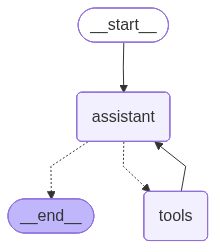

In [25]:
# Visualize the agent graph
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START → assistant → [conditional] → tools → assistant → END")

**🎨 Notice the difference from Topic 1:**
- Topic 1: Linear (START → assistant → END)
- Topic 2: Has a **cycle** (tools can loop back to assistant)

This is agentic behavior - the agent can use tools multiple times if needed!

---
## Section 7: Testing the Tool-Using Agent

In [26]:
# Helper function
def run_agent(user_input: str, thread_id: str = "test_session"):
    """
    Run the agent and display the conversation.
    """
    print(f"\n{'='*70}")
    print(f"👤 User: {user_input}")
    print(f"{'='*70}\n")
    
    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )
    
    for message in result["messages"]:
        if isinstance(message, HumanMessage):
            continue  # Already printed
        elif isinstance(message, AIMessage):
            if message.tool_calls:
                print(f"🤖 Agent: [Calling tool: {message.tool_calls[0]['name']}]")
            else:
                print(f"🤖 Agent: {message.content}")
        elif isinstance(message, ToolMessage):
            print(f"🔧 Tool Result: {message.content[:100]}..." if len(message.content) > 100 else f"🔧 Tool Result: {message.content}")
    
    print(f"\n{'='*70}\n")

print("✅ Test function ready")

✅ Test function ready


### Test 1: Calculator Tool

In [27]:
run_agent("What is 12345 * 67890?")


👤 User: What is 12345 * 67890?

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 838102050
🤖 Agent: The result of \( 12345 \times 67890 \) is 838,102,050.




**🎯 Expected Flow:**
1. Agent sees it needs to calculate
2. Calls calculator tool
3. Gets result from tool
4. Returns formatted answer

### Test 2: Text Analyzer Tool

In [28]:
run_agent("Analyze this text: 'RAG systems combine retrieval with generation. They are very useful!'")


👤 User: Analyze this text: 'RAG systems combine retrieval with generation. They are very useful!'

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 838102050
🤖 Agent: The result of \( 12345 \times 67890 \) is 838,102,050.
🤖 Agent: [Calling tool: text_analyzer]
🔧 Tool Result: Text Analysis:
- Characters: 68
- Words: 10
- Sentences: 2
- First 50 chars: RAG systems combine ret...
🤖 Agent: Here is the analysis of the text:

- **Characters**: 68
- **Words**: 10
- **Sentences**: 2
- **First 50 characters**: RAG systems combine retrieval with generation. The...




### Test 3: No Tool Needed

In [29]:
run_agent("Hello! What can you help me with?")


👤 User: Hello! What can you help me with?

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 838102050
🤖 Agent: The result of \( 12345 \times 67890 \) is 838,102,050.
🤖 Agent: [Calling tool: text_analyzer]
🔧 Tool Result: Text Analysis:
- Characters: 68
- Words: 10
- Sentences: 2
- First 50 chars: RAG systems combine ret...
🤖 Agent: Here is the analysis of the text:

- **Characters**: 68
- **Words**: 10
- **Sentences**: 2
- **First 50 characters**: RAG systems combine retrieval with generation. The...
🤖 Agent: Hello! I can assist you with a variety of tasks, including:

1. **Mathematical Calculations**: I can perform calculations and solve mathematical problems.
2. **Text Analysis**: I can analyze text for statistics such as character count, word count, and sentence count.
3. **General Information**: I can provide information on a wide range of topics.

Feel free to ask me anything specific you'd like help with!




**💡 Smart Agent:** Notice it didn't use any tools - it knew a greeting doesn't need tools!

### Test 4: Wrong Tool Choice?

Let's see if the agent chooses the right tool:

In [30]:
run_agent("How many words are in this sentence: 'LangGraph makes building agents easy'?")


👤 User: How many words are in this sentence: 'LangGraph makes building agents easy'?

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 838102050
🤖 Agent: The result of \( 12345 \times 67890 \) is 838,102,050.
🤖 Agent: [Calling tool: text_analyzer]
🔧 Tool Result: Text Analysis:
- Characters: 68
- Words: 10
- Sentences: 2
- First 50 chars: RAG systems combine ret...
🤖 Agent: Here is the analysis of the text:

- **Characters**: 68
- **Words**: 10
- **Sentences**: 2
- **First 50 characters**: RAG systems combine retrieval with generation. The...
🤖 Agent: Hello! I can assist you with a variety of tasks, including:

1. **Mathematical Calculations**: I can perform calculations and solve mathematical problems.
2. **Text Analysis**: I can analyze text for statistics such as character count, word count, and sentence count.
3. **General Information**: I can provide information on a wide range of topics.

Feel free to ask me anything specific you'd like help with!
🤖 Agent: [Calling tool: text_a

**🎯 Expected:** Should use `text_analyzer`, not `calculator`!

### Test 5: Conversational Context with Tools

In [31]:
# First query
run_agent("Calculate 100 * 50", thread_id="calc_session")


👤 User: Calculate 100 * 50

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 5000
🤖 Agent: The result of \( 100 \times 50 \) is 5000.




In [32]:
# Follow-up - does it remember?
run_agent("Now add 1000 to that result", thread_id="calc_session")


👤 User: Now add 1000 to that result

🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 5000
🤖 Agent: The result of \( 100 \times 50 \) is 5000.
🤖 Agent: [Calling tool: calculator]
🔧 Tool Result: 6000
🤖 Agent: Adding 1000 to the previous result gives us 6000.




**🎉 Amazing:** The agent remembers the previous result AND uses the calculator for the new calculation!

---
## Section 8: Understanding Tool Messages

Let's inspect what happens behind the scenes:

In [33]:
# Get full message history
result = agent.invoke(
    {"messages": [HumanMessage(content="What is 15 * 25?")]},
    config={"configurable": {"thread_id": "inspect_session"}}
)

print("\n📋 FULL MESSAGE HISTORY:\n")
for i, msg in enumerate(result["messages"], 1):
    print(f"{i}. {type(msg).__name__}")
    if isinstance(msg, AIMessage) and msg.tool_calls:
        print(f"   Tool Call: {msg.tool_calls[0]['name']}({msg.tool_calls[0]['args']})")
    elif isinstance(msg, ToolMessage):
        print(f"   Content: {msg.content}")
    elif hasattr(msg, 'content'):
        print(f"   Content: {msg.content}")
    print()


📋 FULL MESSAGE HISTORY:

1. HumanMessage
   Content: What is 15 * 25?

2. AIMessage
   Tool Call: calculator({'expression': '15 * 25'})

3. ToolMessage
   Content: 375

4. AIMessage
   Content: 15 * 25 equals 375.



**🔍 Message Flow:**
1. `HumanMessage` - User's query
2. `AIMessage` (with tool_calls) - Agent decides to call calculator
3. `ToolMessage` - Result from calculator tool
4. `AIMessage` (no tool_calls) - Agent's final answer

This is the standard **ReAct** pattern: Reason → Act → Observe → Respond

---
## Section 9: Adding a Third Tool (Bonus)

Let's add one more tool to show how flexible this is:

In [34]:
@tool
def coin_flip() -> str:
    """
    Flip a coin and return heads or tails.
    
    Use this when the user wants a random choice or coin flip.
    
    Returns:
        Either "Heads" or "Tails"
    """
    import random
    return random.choice(["Heads", "Tails"])

# Rebuild agent with 3 tools
tools_v2 = [calculator, text_analyzer, coin_flip]
llm_with_tools_v2 = llm.bind_tools(tools_v2)

def assistant_v2(state: MessagesState) -> dict:
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools_v2.invoke(messages)
    return {"messages": [response]}

builder_v2 = StateGraph(MessagesState)
builder_v2.add_node("assistant", assistant_v2)
builder_v2.add_node("tools", ToolNode(tools_v2))
builder_v2.add_edge(START, "assistant")
builder_v2.add_conditional_edges("assistant", should_continue, {"tools": "tools", "__end__": END})
builder_v2.add_edge("tools", "assistant")

agent_v2 = builder_v2.compile(checkpointer=MemorySaver())

print("✅ Agent v2 created with 3 tools")

✅ Agent v2 created with 3 tools


In [35]:
# Test coin flip
result = agent_v2.invoke(
    {"messages": [HumanMessage(content="Flip a coin for me!")]},
    config={"configurable": {"thread_id": "coin_session"}}
)

for msg in result["messages"]:
    if isinstance(msg, AIMessage) and not msg.tool_calls:
        print(f"🤖 Agent: {msg.content}")

🤖 Agent: The coin flip result is Tails!


**✨ Scalability:** You can add as many tools as you need - the agent will learn to use them all!

---
## Section 10: Preparing for Topic 3 (Agentic RAG)

In Topic 3, we'll create a **retrieval tool** that searches a vector store. It will work exactly like these tools:

```python
@tool
def retrieve_documents(query: str) -> str:
    """Retrieve relevant documents from vector store."""
    docs = vectorstore.similarity_search(query)
    return format_docs(docs)

# Agent will decide: "Do I need to retrieve documents?"
```

This is the foundation of **Agentic RAG** - retrieval controlled by an intelligent agent!

---
## Section 11: Summary

### What You Learned

1. **Why Tools Matter**
   - LLMs can't DO things without tools
   - Tools extend agent capabilities
   - Agents decide when to use tools

2. **Creating Tools**
   - Use `@tool` decorator
   - Write clear docstrings (LLM reads them!)
   - Include examples and error handling

3. **Tool Integration**
   - `bind_tools()` gives LLM awareness of tools
   - OpenAI function calling enables structured tool calls
   - ToolNode executes tools automatically

4. **Conditional Routing**
   - Check `tool_calls` to decide next step
   - Graph can loop back to assistant after tools
   - This enables iterative, multi-step reasoning

5. **ReAct Pattern**
   - **Reason:** Agent analyzes query
   - **Act:** Agent calls appropriate tool
   - **Observe:** Agent sees tool result
   - **Respond:** Agent generates final answer

### What's Next?

**Topic 3: Agentic RAG** ⭐
- Create a retrieval tool using Chroma vector store
- Agent decides when to retrieve vs answer from knowledge
- Build a complete agentic RAG system
- The core concept of this module!

---
## Other Practice Exercises

1. **Create a new tool** that converts temperatures (Celsius ↔ Fahrenheit)
2. **Test tool priority** - what happens if multiple tools could work?
3. **Add error handling** - make a tool that sometimes fails and see how the agent handles it
4. **Multi-tool query** - ask something that requires using TWO tools in sequence
5. **Improve prompts** - modify the system prompt to change tool usage behavior


## 🎯 Practice Exercises
## Exercise 1: Build Your First Stateful Agent

### Task
Create an agent with three custom tools:
1. **Weather tool:** Returns simulated weather for a given city
2. **Dictionary tool:** Looks up word definitions (simulate with a small dict)
3. **Web search tool:** Uses DuckDuckGo to search the web for information

### Requirements
1. Define tools using `@tool` decorator
2. Bind tools to LLM
3. Implement conditional routing (agent decides which tool to use)
4. Handle cases where no tool is needed
5. Install DuckDuckGo search: `pip install duckduckgo-search`
6. Use `DDGS().text()` method for web searches

### Example Queries
- "What's the weather in Lagos?" → Uses weather tool
- "Define the word 'ephemeral'" → Uses dictionary
- "Search for latest AI news" → Uses DuckDuckGo web search
- "What's the capital of France?" → No tool needed


### Answer to Practice Questions

In [36]:
# Install duckduckgo-search

!pip install -q duckduckgo-search


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
# Define tool decorator

from langchain_core.tools import tool
from duckduckgo_search import DDGS

print(f'Tool decorator defined successfully')

Tool decorator defined successfully


In [38]:
# Weather Tool

# @tool
# def weather_tool(city: str) -> str:
#     """Get simulated weather for a city."""
#     data = {
#         "Lagos": "It is sunny and 30°C in Lagos.",
#         "Abeokuta": "It is cloudy and 27°C in Abeokuta.",
#         "Kano": "It is extremely hot and 35°C in Kano."
#     }
#     return data.get(city.lower(), f"No weather data for {city}.")


@tool
def weather_tool(city: str) -> str:
    """Get simulated weather for a city."""
    city_key = city.strip().lower()

    data = {
        "port harcourt": "It is sunny and 30°C in port harcourt.",
        "abeokuta": "It is cloudy and 26°C in abeokuta.",
        "kano": "The weather in kano is 35°C."
    }

    return data.get(city_key, f"No weather data for {city}.")



In [39]:
# Dictionary Tool

@tool
def dictionary_tool(word: str) -> str:
    """Return the definition of a word."""
    dictionary = {
        "ephemeral": "Lasting for a very short time.",
        "ubiquitous": "Present everywhere.",
        "resilient": "Able to recover quickly from difficulty."
    }
    return dictionary.get(word.lower(), f"No definition found for '{word}'.")


In [40]:
# Web Search Tool

from duckduckgo_search import DDGS

@tool
def web_search_tool(query: str) -> str:
    """Search the web using DuckDuckGo."""
    with DDGS() as ddgs:
        results = ddgs.text(query, max_results=3)
        return "\n".join(r["body"] for r in results) or "No results found for your search. Try again next time."


In [41]:
# Bind tools to the LLM

tools = [weather_tool, dictionary_tool, web_search_tool]

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7
).bind_tools(tools)


In [42]:
# System Prompt

system_prompt = SystemMessage(
    content=(
        "You are a helpful assistant. "
        "Use tools when necessary. "
        "If no tool is needed or required, answer directly."
    )
)

print(f"System Prompt initialized successfully")

System Prompt initialized successfully


In [43]:
# Agent Node

def agent_node(state: MessagesState):
    messages = [system_prompt] + state["messages"]
    response = llm.invoke(messages)
    return {"messages": state["messages"] + [response]}


In [44]:
# Tool Node

tool_node = ToolNode(tools)


In [45]:
# Conditional Routing Logic

def should_use_tool(state: MessagesState) -> Literal["tools", "__end__"]:
    last = state["messages"][-1]
    if getattr(last, "tool_calls", None):
        return "tools"
    return END


In [46]:
# Build Graph

graph = StateGraph(MessagesState)

graph.add_node("agent", agent_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "agent")

graph.add_conditional_edges(
    "agent",
    should_use_tool,
    {
        "tools": "tools",
        END: END
    }
)

graph.add_edge("tools", "agent")

print(f"LangGraph built successfully")


LangGraph built successfully


In [47]:
# Compile with memory

memory = MemorySaver()
app = graph.compile(checkpointer=memory)


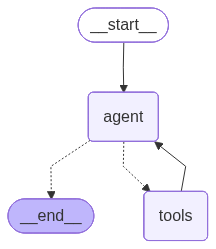

In [48]:
# Display Graph
display(Image(app.get_graph().draw_mermaid_png()))


In [49]:
# Let us see if it works as intended

config = {"configurable": {"thread_id": "demo"}}

app.invoke(
    {"messages": [HumanMessage(content="What's the weather in kano?")]},
    config=config
)


{'messages': [HumanMessage(content="What's the weather in kano?", additional_kwargs={}, response_metadata={}, id='ebecb589-358b-4742-92c2-5916e1fb80fc'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 116, 'total_tokens': 131, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'id': 'chatcmpl-CtVewClhrmfmJej15UkIR0h7ar3DA', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b7e04-5c35-76c3-a84a-c9dbb9b82a62-0', tool_calls=[{'name': 'weather_tool', 'args': {'city': 'Kano'}, 'id': 'call_5hiurmkFdLExtGBW1QaleIja', 'type': 'tool_call'}], usage_metadata={'input_tokens': 116, 'output_tokens': 15, 'total_t

---
## Reflection Questions

1. **How does the agent "know" which tool to use?**
   
2. **What role does the tool docstring play?**
   
3. **Why do we need conditional edges for tool-using agents?**
   
4. **What would happen if we didn't loop back to assistant after tools?**
   
5. **How is this different from just calling functions in regular Python code?**

Think about these before moving to Topic 3!

---


**🎉 Topic 2 Complete!**

You now know how to build agents that use tools! Next: **Agentic RAG** - where retrieval becomes a tool that agents control!